### Sample program for LSTM (N-d input/output)  
https://oku.edu.mie-u.ac.jp/~okumura/stat/160118.html  

#### Import libraries  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

2021-10-13 20:52:28.428399: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-13 20:52:28.428425: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#### Parameters  

In [2]:
np.random.seed(11)
tf.random.set_seed(11)

# To show more rows and columns without "..."
pd.options.display.max_columns=999
pd.options.display.max_rows=999

#### Read CSV file  

In [3]:
# read data
df = pd.read_csv('weather_in_tokyo_and_icecream_in_japan-utf8.csv',
                 delimiter=',',skiprows=6, header=0)
print(df.shape)
print(df.info())
display(df.head())

(120, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   120 non-null    object 
 1   x1      120 non-null    float64
 2   x2      120 non-null    float64
 3   x3      120 non-null    int64  
 4   x4      120 non-null    int64  
 5   y1      120 non-null    int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 5.8+ KB
None


,Month,x1,x2,x3,x4,y1
0,2003-1,9.3,101.0,46,0,331
1,2003-2,9.9,53.5,52,0,268
2,2003-3,12.7,159.5,49,0,365
3,2003-4,19.2,121.0,61,3,492
4,2003-5,22.4,172.5,65,7,632


#### Convert datatype of Month column to 'datetime'  

In [4]:
df['Month'] = pd.to_datetime(df['Month'])
print(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Month   120 non-null    datetime64[ns]
 1   x1      120 non-null    float64       
 2   x2      120 non-null    float64       
 3   x3      120 non-null    int64         
 4   x4      120 non-null    int64         
 5   y1      120 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 5.8 KB
None


,Month,x1,x2,x3,x4,y1
0,2003-01-01,9.3,101.0,46,0,331
1,2003-02-01,9.9,53.5,52,0,268
2,2003-03-01,12.7,159.5,49,0,365
3,2003-04-01,19.2,121.0,61,3,492
4,2003-05-01,22.4,172.5,65,7,632


#### Time series plot  

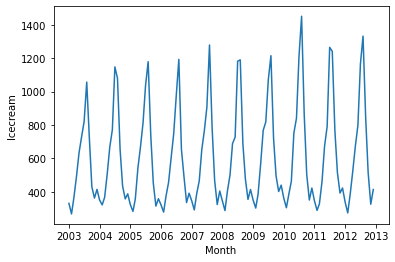

In [5]:
plt.plot(df['Month'], df['y1'])
plt.xlabel('Month')
plt.ylabel('Icecream')
plt.show()

#### Set parameters for training / prediction  

In [6]:
w = 24
n_out = 12
n_test = 12

#### Standardization of training data  

In [7]:
sc = MinMaxScaler(feature_range=(0, 1), copy=True)
xy = df.drop(columns='Month')
sc.fit(xy[:-n_test])
xy_std = sc.transform(xy)
print(xy_std.shape)

(120, 5)


#### Prepare for train data and teacher signal  

In [8]:
weather = xy_std[:, 2:-1]
print(weather.shape)
display(weather[:5])

(120, 2)


array([[0.25641026, 0.        ],
       [0.41025641, 0.        ],
       [0.33333333, 0.        ],
       [0.64102564, 0.09677419],
       [0.74358974, 0.22580645]])

In [9]:
icecream = xy_std[:, -1]
print(icecream.shape)
print(icecream[:5])
print(icecream)

(120,)
[0.05325444 0.         0.08199493 0.18934911 0.30769231]
[0.05325444 0.         0.08199493 0.18934911 0.30769231 0.39053254
 0.46745562 0.66694844 0.38546069 0.13693998 0.08030431 0.12426036
 0.07016061 0.04564666 0.08368555 0.20287405 0.33727811 0.4260355
 0.74387151 0.68639053 0.32544379 0.14032122 0.07607777 0.10143702
 0.04649197 0.01267963 0.07523246 0.23245985 0.33727811 0.45984784
 0.65004227 0.77007608 0.39814032 0.15638208 0.0397295  0.07692308
 0.04564666 0.00929839 0.0887574  0.15976331 0.28233305 0.4057481
 0.59594252 0.7819104  0.3262891  0.19019442 0.05748098 0.10481826
 0.06677937 0.0202874  0.10059172 0.16737109 0.32459848 0.42265427
 0.54099746 0.85460693 0.43617921 0.16990702 0.04733728 0.11580727
 0.06593407 0.01690617 0.11496196 0.19695689 0.35587489 0.38799662
 0.772612   0.77937447 0.35756551 0.17666948 0.07354184 0.12341505
 0.07016061 0.0295858  0.09974641 0.25443787 0.42265427 0.465765
 0.67962806 0.80050719 0.38461538 0.19188504 0.11327134 0.14539307
 0

#### Prepare for windows of data  

In [10]:
x = []
y = []

n_months = icecream.shape[0]

for i in range(0, n_months-w-n_out):
    x.append(weather[i:i+w])
    y.append(icecream[i+w:i+w+n_out])
x = np.array(x)
y = np.array(y)
print(x.shape, y.shape)  # debug
print(x[:3])
print(y[:3])

(84, 24, 2) (84, 12)
[[[0.25641026 0.        ]
  [0.41025641 0.        ]
  [0.33333333 0.        ]
  [0.64102564 0.09677419]
  [0.74358974 0.22580645]
  [0.84615385 0.67741935]
  [1.         0.67741935]
  [0.94871795 0.83870968]
  [0.76923077 0.74193548]
  [0.58974359 0.09677419]
  [0.79487179 0.        ]
  [0.35897436 0.        ]
  [0.17948718 0.        ]
  [0.23076923 0.        ]
  [0.43589744 0.        ]
  [0.38461538 0.09677419]
  [0.79487179 0.41935484]
  [0.76923077 0.77419355]
  [0.66666667 1.        ]
  [0.74358974 0.90322581]
  [0.82051282 0.83870968]
  [0.84615385 0.09677419]
  [0.61538462 0.        ]
  [0.33333333 0.        ]]

 [[0.41025641 0.        ]
  [0.33333333 0.        ]
  [0.64102564 0.09677419]
  [0.74358974 0.22580645]
  [0.84615385 0.67741935]
  [1.         0.67741935]
  [0.94871795 0.83870968]
  [0.76923077 0.74193548]
  [0.58974359 0.09677419]
  [0.79487179 0.        ]
  [0.35897436 0.        ]
  [0.17948718 0.        ]
  [0.23076923 0.        ]
  [0.43589744 0

#### Model building  

In [11]:
n_hidden = 20

# early stopping and model checkpoint
es_cb = EarlyStopping(monitor='val_loss',
                      patience=10, verbose=1, mode='auto')

model = Sequential()
model.add(LSTM(n_hidden, input_shape=(x.shape[1],x.shape[2]),
               return_sequences=False))
model.add(Dense(n_out, activation='linear'))

model.summary()

2021-10-13 20:52:31.280893: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-13 20:52:31.280936: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-13 20:52:31.280953: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (anhvu): /proc/driver/nvidia/version does not exist
2021-10-13 20:52:31.281408: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                1840      
_________________________________________________________________
dense (Dense)                (None, 12)                252       
Total params: 2,092
Trainable params: 2,092
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(loss="mean_squared_error", optimizer='adam')

#### Training (learning)  

In [13]:
%%time

# Learning 
n_epochs = 500
val_split = 0.2
batch_size = 1

fit_log = model.fit(x[:-n_test], y[:-n_test], batch_size=batch_size, epochs=n_epochs,
                    validation_split=val_split, callbacks=[es_cb])

Epoch 1/500


2021-10-13 20:52:31.755382: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


57/57 [==============================] - 2s 12ms/step - loss: 0.0846 - val_loss: 0.0853
Epoch 2/500
57/57 [==============================] - 0s 5ms/step - loss: 0.0593 - val_loss: 0.0818
Epoch 3/500
57/57 [==============================] - 0s 4ms/step - loss: 0.0538 - val_loss: 0.0780
Epoch 4/500
57/57 [==============================] - 0s 6ms/step - loss: 0.0490 - val_loss: 0.0727
Epoch 5/500
57/57 [==============================] - 0s 4ms/step - loss: 0.0437 - val_loss: 0.0633
Epoch 6/500
57/57 [==============================] - 0s 7ms/step - loss: 0.0363 - val_loss: 0.0493
Epoch 7/500
57/57 [==============================] - 0s 5ms/step - loss: 0.0272 - val_loss: 0.0383
Epoch 8/500
57/57 [==============================] - 0s 6ms/step - loss: 0.0201 - val_loss: 0.0300
Epoch 9/500
57/57 [==============================] - 0s 4ms/step - loss: 0.0157 - val_loss: 0.0263
Epoch 10/500
57/57 [==============================] - 0s 6ms/step - loss: 0.0141 - val_loss: 0.0246
Epoch 11/500
57/57 [

#### Do prediction  

In [14]:
# Against training data
pred = model.predict(x[:-n_test])
print(pred.shape)  # debug

(72, 12)


In [15]:
# Future prediction
future_test = x[-n_test:]
print(future_test.shape)
print(future_test[:3])

(12, 24, 2)
[[[0.30769231 0.        ]
  [0.35897436 0.        ]
  [0.30769231 0.        ]
  [0.46153846 0.03225806]
  [0.71794872 0.29032258]
  [0.92307692 0.51612903]
  [0.92307692 0.90322581]
  [0.84615385 0.96774194]
  [0.71794872 0.67741935]
  [0.71794872 0.16129032]
  [0.69230769 0.03225806]
  [0.38461538 0.        ]
  [0.12820513 0.        ]
  [0.61538462 0.        ]
  [0.64102564 0.        ]
  [0.66666667 0.03225806]
  [0.61538462 0.25806452]
  [0.79487179 0.77419355]
  [0.87179487 1.        ]
  [0.79487179 1.        ]
  [0.82051282 0.70967742]
  [0.82051282 0.19354839]
  [0.51282051 0.        ]
  [0.35897436 0.        ]]

 [[0.35897436 0.        ]
  [0.30769231 0.        ]
  [0.46153846 0.03225806]
  [0.71794872 0.29032258]
  [0.92307692 0.51612903]
  [0.92307692 0.90322581]
  [0.84615385 0.96774194]
  [0.71794872 0.67741935]
  [0.71794872 0.16129032]
  [0.69230769 0.03225806]
  [0.38461538 0.        ]
  [0.12820513 0.        ]
  [0.61538462 0.        ]
  [0.64102564 0.        

In [16]:
future_result = model.predict(future_test)
print(future_result.shape)

(12, 12)


#### Generalization performance  

In [17]:
mse = mean_squared_error(y[-n_test:], future_result)
print('mse=', mse)

mse= 0.0036265495639931297


#### Plot of the results  

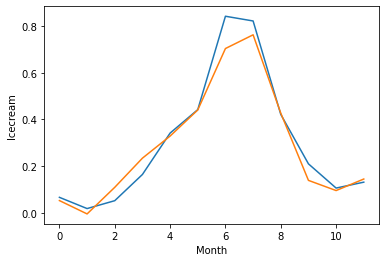

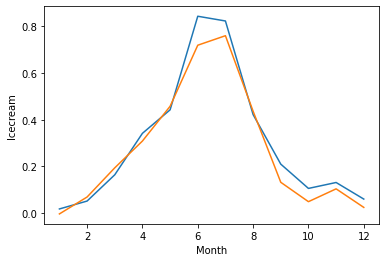

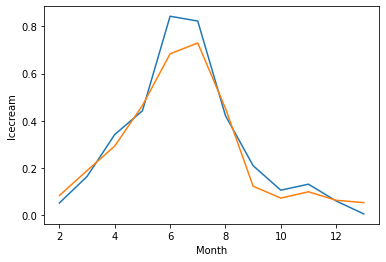

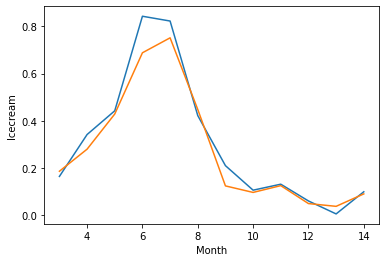

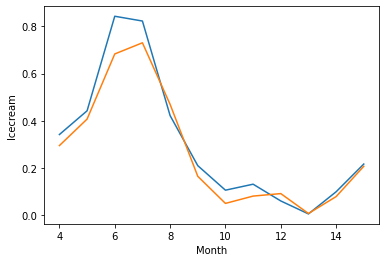

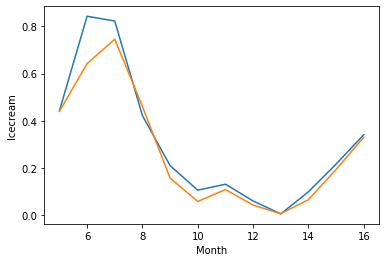

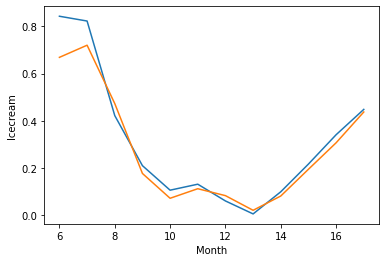

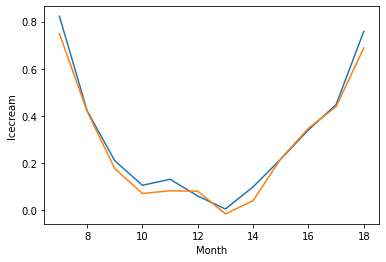

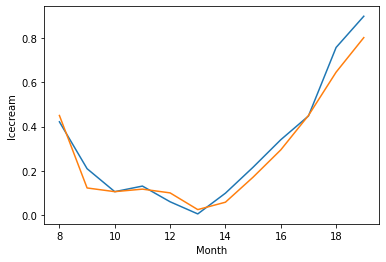

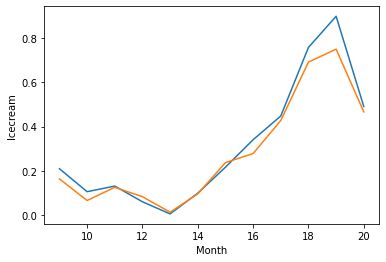

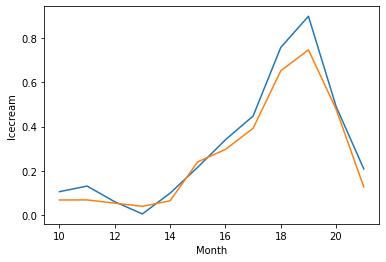

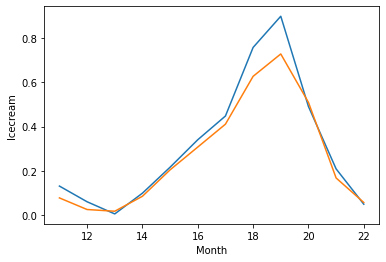

In [18]:
for i in range(n_test):
    plt.plot(range(i,i+n_out), y[i-n_test])
    plt.plot(range(i,i+n_out), future_result[i])
    plt.xlabel('Month')
    plt.ylabel('Icecream')
    plt.show()

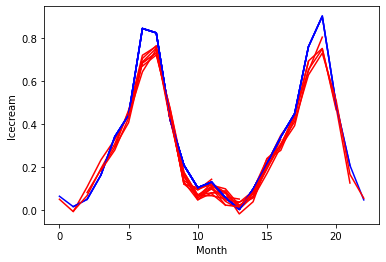

In [19]:
for i in range(n_test):
    plt.plot(range(i,i+n_out), y[i-n_test], c='b')
    plt.plot(range(i,i+n_out), future_result[i], c='r')
plt.xlabel('Month')
plt.ylabel('Icecream')
plt.show()

#### Plot of the log during the training  

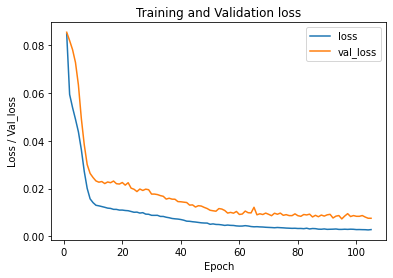

In [20]:
# Plot Training loss & Validation Loss
loss = fit_log.history["loss"]
val_loss = fit_log.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, label="loss" )
plt.plot(epochs, val_loss, label="val_loss")
plt.title("Training and Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss / Val_loss')
plt.legend()
plt.show()